In [3]:
import pyaudio
import wave
import numpy as np

class GuitarInterface(object):
    
    def __init__(self, audio_device_name="JAM 96k", audio_format=pyaudio.paInt16, channels=1, rate=44100,
                 chunk_size=1024):
        
        # Store some values that we'll need easy access to
        self.audio_format = audio_format
        self.channels = channels
        self.rate = rate
        self.chunk_size = chunk_size
        
        # Initialize the Audio library and device
        self.audio = pyaudio.PyAudio()
        self.audio_device_id = [i for i in range(self.audio.get_device_count()) if self.audio.get_device_info_by_index(i)['name'] == audio_device_name][0]
    
    """
        Capture a number of seconds worth of audio input from the pyAudio device initialized.
        Returns:
            SoundSample: representing the audio captured
    """
    def capture_audio(self, secs=5):
        stream = self.audio.open(format=self.audio_format, channels=self.channels, rate=self.rate, input=True,
                                input_device_index=self.audio_device_id, frames_per_buffer=self.chunk_size)

        frames = stream.read(self.rate * secs)
        
        # stop Recording and properly close the stream
        stream.stop_stream()
        stream.close()
        #self.audio.terminate()
        return SoundSample(frames, secs)
    
    """
        Save a .wav file that can be played back from a SoundSample - 
        Should be saved with the same audio interface that it was created with (so datatypes match)
        
    """
    def save_byte_frames(self, sound_sample, output_filename="audio_output.wav"):
        
        print ("Saving audio sample to: {}".format(output_filename))
        waveFile = wave.open(output_filename, 'wb')
        waveFile.setnchannels(self.channels)
        waveFile.setsampwidth(self.audio.get_sample_size(self.audio_format))
        waveFile.setframerate(self.rate)
        waveFile.writeframes(b''.join(sound_sample.asByteList))
        waveFile.close()
        print("Finished writing file.")
        
        
# A small class to wrap up some useful sound sample conversion methods
# This class doesn't cache the generated lists - this might be a useful optimization at Train time.
class SoundSample(object):
    
    def __init__(self, sample_stream, length, np_datatype='Int16'):
        self.audio_length = length # length in seconds
        self.np_datatype = np_datatype
        self.sample_stream = sample_stream
    
    @property
    def length(self):
        return self.audio_length
    
    @property
    def stream(self):
        return self.sample_stream
    
    @property
    def asList(self):
        data = np.fromstring(self.sample_stream, self.np_datatype)
        return data
    
    @property
    def asByteList(self):
        return [a for a in self.sample_stream]


In [19]:
#a = raw_input("give me something!")
#print(a)
import uuid
print(uuid.uuid4())

import time
from IPython.display import clear_output

for f in range(10):
    clear_output(wait=True)
    print(f)
    time.sleep(1)

9


In [4]:
gi = GuitarInterface()

# Let's create a dynamic recorder
duration = raw_input("")


# We should record a reference for white noise - so let's record nothing at all
raw_input("Let's also record a reference clip for white noise - press enter, but don't play anything")
sample = gi.capture_audio(secs=3)
print("Recording Finished...")
white_noise = sample
gi.save_byte_frames(sample, "monophonic_data/white_noise.wav")

# OK, so let's record 2 interesting clips - First we'll start off with a C Major Scale - low to high
raw_input("Press Enter - Time to play a C Major Scale - Low C to High C as noted above.")
sample = gi.capture_audio(secs=3)
print("Recording Finished...")
c_major_scale = sample
gi.save_byte_frames(sample, "monophonic_data/c_major_scale.wav")

# Now maybe we'll record something more interesting
raw_input("Press Enter - Experimental Blues Scale")
sample = gi.capture_audio(secs=3)
e_blues_scale = sample
gi.save_byte_frames(sample, "monophonic_data/e_blues_scale.wav")

print("All set!")


Let's also record a reference clip for white noise - press enter, but don't play anything
Recording Finished...
Saving audio sample to: monophonic_data/white_noise.wav
Finished writing file.
Press Enter - Time to play a C Major Scale - Low C to High C as noted above.
Recording Finished...
Saving audio sample to: monophonic_data/c_major_scale.wav
Finished writing file.
Press Enter - Experimental Blues Scale
Saving audio sample to: monophonic_data/e_blues_scale.wav
Finished writing file.
All set!


In [6]:
audio_samples = [(c_major_scale, "c_major_scale"), (e_blues_scale, "e_blues_scale")]

/Users/raymondklass/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:73: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


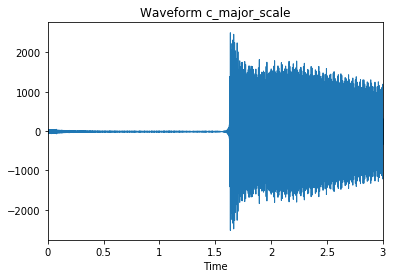

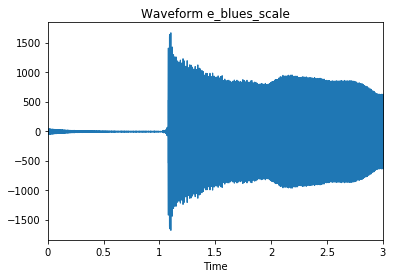

In [7]:
# data_key -> key of note names
# data_audio -> audio recording (SoundSamples)

# Let's try loading one of the samples with librosa
import matplotlib.pyplot as plt
import librosa
import librosa.display

for sample, title in audio_samples:
    y, sr = sample.asList.astype(float), 44100
    plt.figure()
    librosa.display.waveplot(y, sr=sr)
    plt.title("Waveform {}".format(title))
    plt.show()

/Users/raymondklass/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:73: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
/Users/raymondklass/anaconda2/lib/python2.7/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


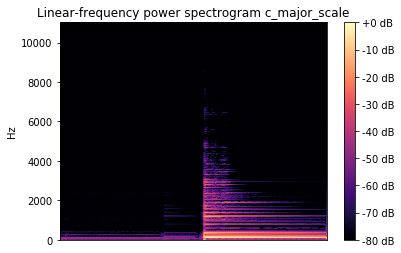

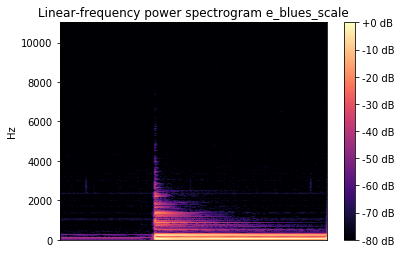

In [8]:
# Let's try visualizing the spectrum plot
for sample, title in audio_samples:
    y, sr = sample.asList.astype(float), 44100
    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Linear-frequency power spectrogram {}".format(title))
    plt.show()

/Users/raymondklass/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:73: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


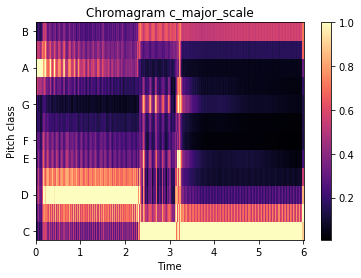

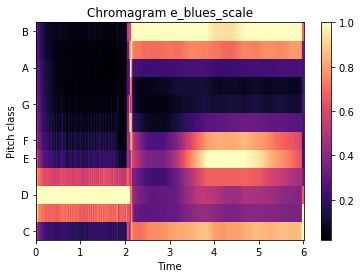

In [10]:
# Explore Chroma SFTP features

for sample, title in audio_samples:
    y, sr = sample.asList.astype(float), 44100
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title("Chromagram {}".format(title))
    plt.show()


/Users/raymondklass/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:73: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


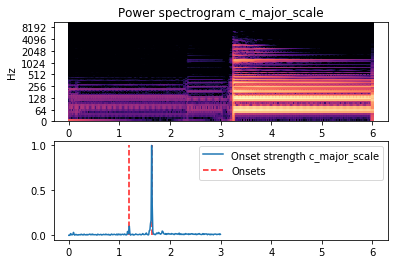

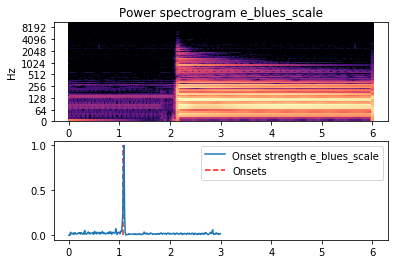

In [11]:
# let's play around with onset detection
for sample, title in audio_samples:
    y, sr = sample.asList.astype(float), 44100
    
    o_env = librosa.onset.onset_strength(y, sr=sr)
    times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
    onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)
    
    D = librosa.stft(y)
    plt.figure()
    ax1 = plt.subplot(2, 1, 1)
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                              x_axis='time', y_axis='log')
    plt.title("Power spectrogram {}".format(title))
    plt.subplot(2, 1, 2, sharex=ax1)
    plt.plot(times, o_env, label="Onset strength {}".format(title))
    plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
               linestyle='--', label='Onsets')
    plt.axis('tight')
    plt.legend(frameon=True, framealpha=0.75)
    plt.show()
    